In [63]:
library(tidymodels)
library(readxl)
library(lubridate)



car_data <- read_xlsx("carbitrage-data.xlsx")

`summarise()` has grouped output by 'make'. You can override using the
`.groups` argument.


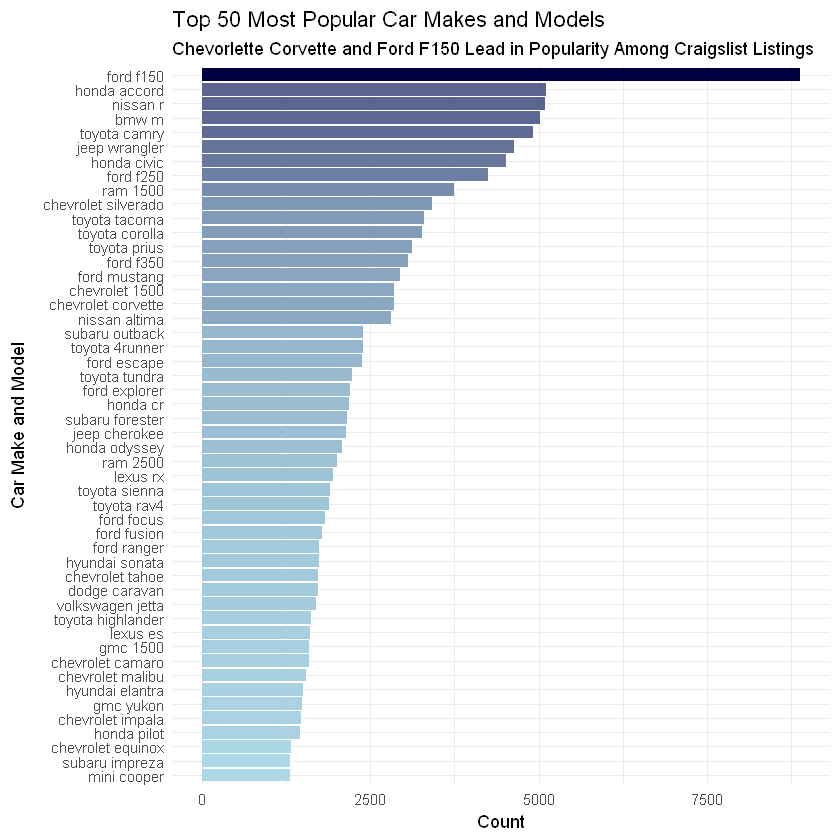

In [64]:
cleaned_data <- recipe(~., data = car_data) %>%
    step_naomit(all_predictors()) %>%
    prep() %>%
    juice()


# First Visuzalizations
data_for_viz = cleaned_data %>%
    group_by(make, model) %>%
    summarise(count = n()) %>%
    arrange(desc(count))


top_car_counts <- head(data_for_viz, 50)

ggplot(data = top_car_counts, aes(y = reorder(paste(make, model), count), x = count, fill = count)) +
    geom_bar(stat = "identity") +
    scale_fill_gradient(low = "lightblue", high = "#010141") +
    theme_minimal() +
    labs(y = "Car Make and Model", x = "Count", title = "Top 50 Most Popular Car Makes and Models", subtitle = "Chevorlette Corvette and Ford F150 Lead in Popularity Among Craigslist Listings") +
    theme(legend.position = "none",plot.title = element_text(hjust = 0), plot.subtitle = element_text(hjust = 0))


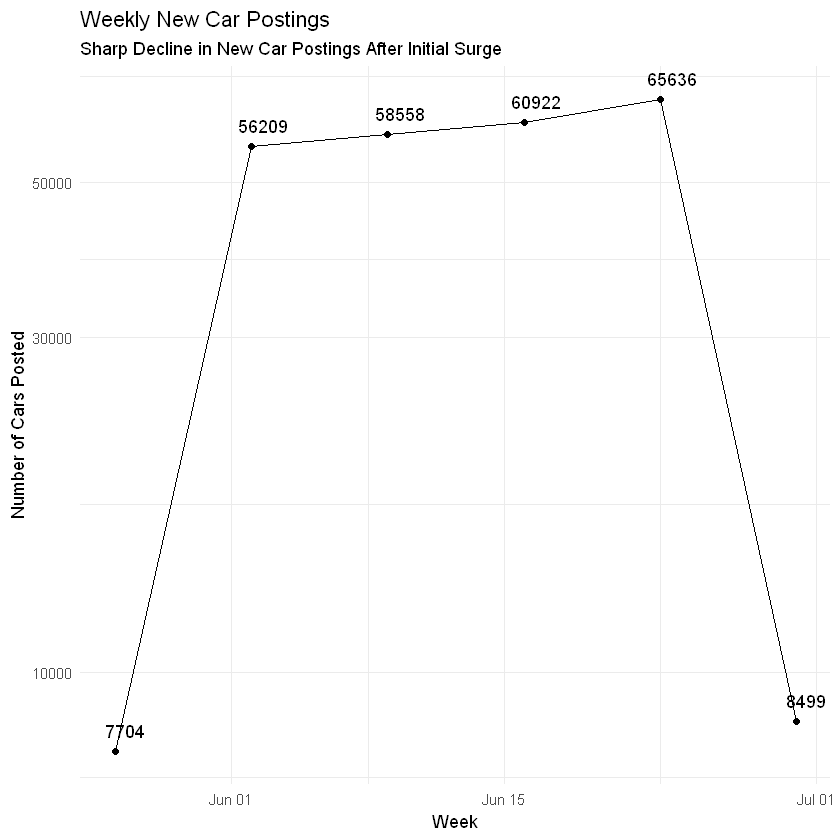

In [65]:

cleaned_data2 <- cleaned_data

cleaned_data2$time_posted <- as.Date(cleaned_data$time_posted)



# daily_plot <- cleaned_data2 %>%
#     group_by(time_posted) %>%
#     summarise(Count = n()) %>%
#     ggplot(aes(x = time_posted, y = Count)) +
#     geom_line() +
#     theme_minimal() +
#     labs(x = "Date", y = "Frequency", title = "Postings Per Day") +
#     geom_text(aes(label = ifelse(time_posted == as.Date("2024-07-03"), Count, "")), vjust = -1, hjust = 1) +
#     geom_point(aes(x = time_posted, y = Count))

# daily_plot

weekly_data <- cleaned_data2 %>%
    mutate(week = floor_date(time_posted, unit = "week")) %>% # Create a new 'week' column by rounding dates to the start of the week
    group_by(week) %>%
    summarise(Count = n())

ggplot(data = weekly_data, aes(x = week, y = Count)) +
    geom_line() +
    scale_y_log10() +
    labs(title = "Weekly New Car Postings", x = "Week", y = "Number of Cars Posted", subtitle = "Sharp Decline in New Car Postings After Initial Surge") +
    geom_text(aes(label = Count), vjust = -1, hjust = .25) +
    geom_point(aes(x = week, y = Count)) +
    theme_minimal() +
    theme(plot.title = element_text(hjust = 0), plot.subtitle = element_text(hjust = 0))

`summarise()` has grouped output by 'location'. You can override using the
`.groups` argument.


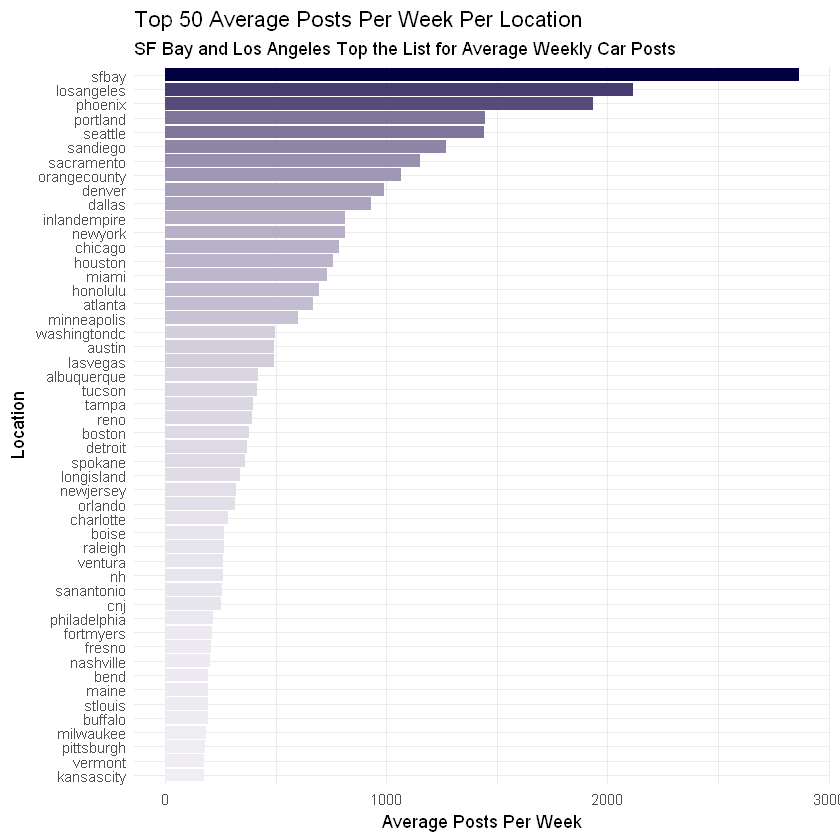

In [66]:
location_data = cleaned_data2 %>%
    mutate(week = floor_date(time_posted, unit = "week")) %>%
    group_by(location,week) %>%
    summarise(count = n())

location_data_50 = location_data %>%
    group_by(location) %>%
    summarise(avg = mean(count)) %>%
    arrange(desc(avg)) %>%
    head(50)



ggplot(data = location_data_50, aes(x = avg, y = reorder(location, avg), fill = avg)) +
    geom_bar(stat = "identity") +
    scale_fill_gradient2(low = "lightblue", high = "#010141") +
    theme_minimal() +
    theme(legend.position = "none") +
    labs(y = "Location", x = "Average Posts Per Week", title = "Top 50 Average Posts Per Week Per Location", subtitle = "SF Bay and Los Angeles Top the List for Average Weekly Car Posts") +
    theme(plot.title = element_text(hjust = 0), plot.subtitle = element_text(hjust = 0))

`summarise()` has grouped output by 'location'. You can override using the
`.groups` argument.


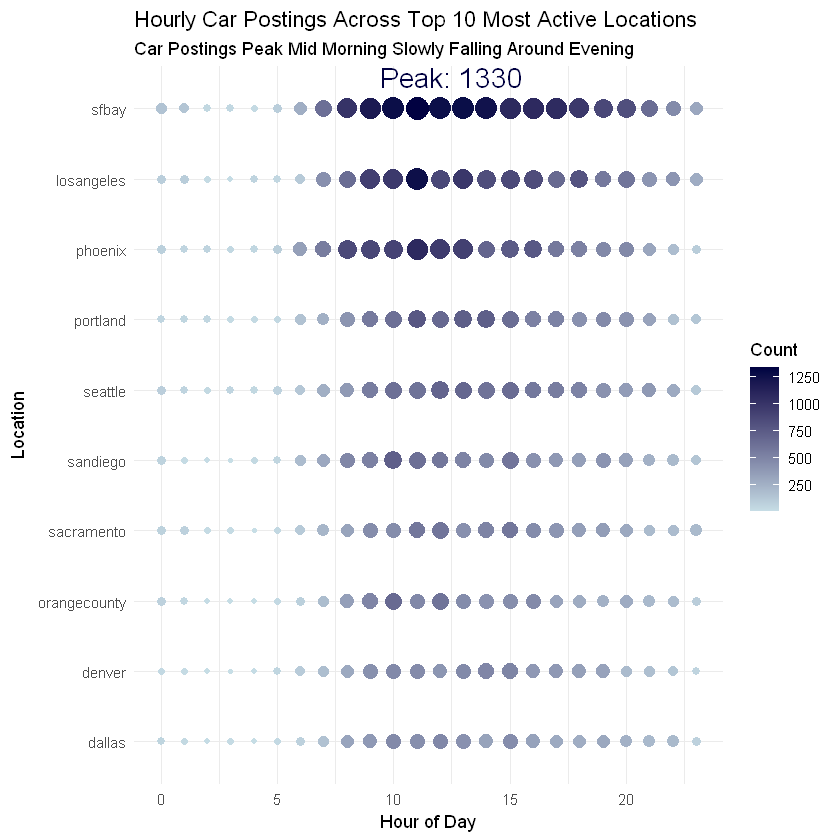

In [67]:
fourth_viz_data = cleaned_data

fourth_viz_data$time_posted = as.POSIXct(cleaned_data$time_posted, format = "%Y-%m-%d %H:%M:%S", tz = "UTC")

location_data_25 <- location_data %>%
    group_by(location) %>%
    summarise(avg = mean(count)) %>%
    arrange(desc(avg)) %>%
    head(10)


fourth_viz_data = fourth_viz_data %>%
    mutate(hour = hour(time_posted)) %>%
    filter(location %in% location_data_25$location)

fourth_viz_data = fourth_viz_data %>%
    group_by(location, hour) %>%
    summarise(count = n()) %>%
    arrange(desc(count)) %>%
    ungroup()


ggplot(data = fourth_viz_data, aes(y = reorder(location,count), x = hour, size = count, color = count)) +
    geom_point(alpha = 1, show.legend = FALSE) +
    scale_size_continuous(range = c(1, 6)) +
    scale_color_gradient(
        low = "#c7dee6", 
        high = "#010141") +
    labs(
        title = "Hourly Car Postings Across Top 10 Most Active Locations",
        subtitle = "Car Postings Peak Mid Morning Slowly Falling Around Evening",
        x = "Hour of Day", y = "Location", size = NULL, color = "Count"
    ) +
        theme(
            axis.title.x = element_text(size = 14),
            axis.text.y = element_text(size = 12),
            axis.title.y = element_text(size = 14),
            legend.position = "none"
        ) +
        geom_text(
            data = subset(fourth_viz_data, count == max(count)),
            aes(label = paste("Peak:", count)),
            vjust = -1, hjust = .25
        ) +
        guides(size = "none") +
        theme_minimal() +

    theme(plot.title = element_text(hjust = 0), plot.subtitle = element_text(hjust = 0))




# ggplot(data = fourth_viz_data, aes(y = count, x = hour, group = location, color = location)) +
#     geom_line(linewidth = 1)+
#     theme_minimal()


### 5th Visualization

In [68]:
make_and_model = cleaned_data %>%
    filter(make == "ford", model == "f150") %>%
    mutate(age = 2024 - year)

q1 = quantile(make_and_model$odometer, .25)
q3 = quantile(make_and_model$odometer, .75)

IQR_ = q3 -q1

lower_bound = q1 - 1.5 * IQR

higher_bound = q3 + 1.5 * IQR


q1_age = quantile(make_and_model$age, .25)
q3_age = quantile(make_and_model$age, .75)

IQR_age = q3_age -q1_age

lower_bound_age = q1_age - 1.5 * IQR_age

higher_bound_age = q3_age + 1.5 * IQR_age


make_and_model = make_and_model %>%
    filter(odometer >= lower_bound & odometer <= higher_bound & age >= lower_bound_age & age <= higher_bound_age)

`geom_smooth()` using formula = 'y ~ x'


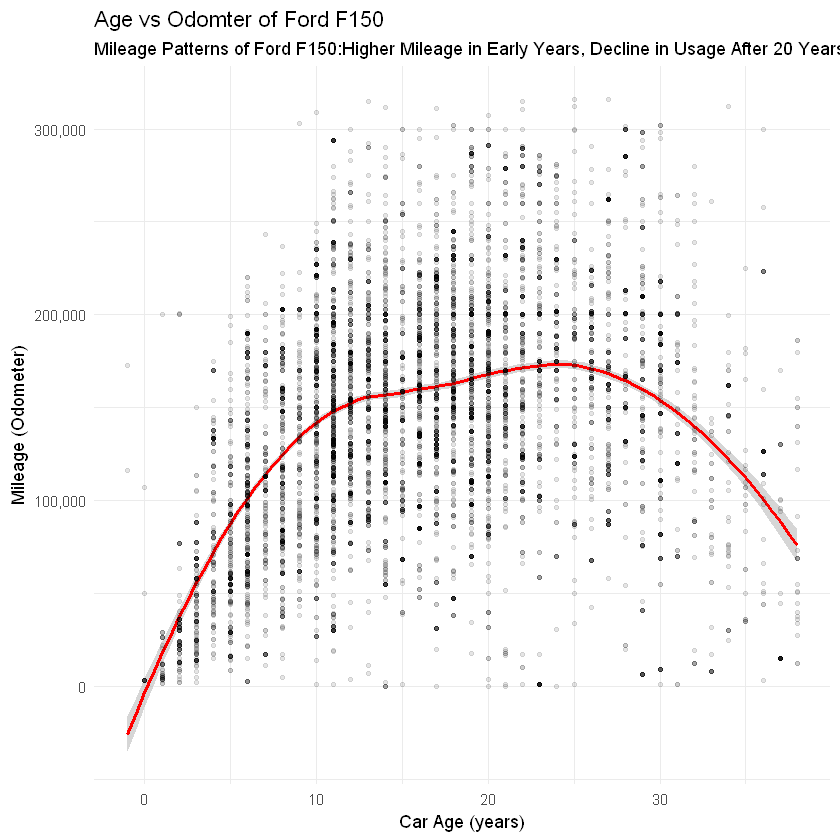

In [72]:

ggplot(data = make_and_model, aes(x = age, y = odometer)) +
    geom_smooth(method = "loess", color = "red", se = TRUE) +
    geom_point(alpha = .10, size = 1) +
    labs(
        title = "Age vs Odomter of Ford F150",
        subtitle = "Mileage Patterns of Ford F150:Higher Mileage in Early Years, Decline in Usage After 20 Years",
        x = "Car Age (years)",
        y = "Mileage (Odometer)"
    ) +
    scale_y_continuous(labels = label_comma()) +
    theme_minimal() +
    theme(plot.title = element_text(hjust = 0), plot.subtitle = element_text(hjust = 0))